In [1]:
import os
import re
import random
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [154]:
image_dir = "../data/plans/with_symbols"

image_list = os.listdir(image_dir)
image_paths = [image_dir + "/" + image_list[i] for i in range(len(image_list))]

#### Extract data from csv label_file (output from label-studio) into two lists:
*   **data** (to be cleaned in the next step)
*   **fnames_labelfile**

In [155]:
label_file = "../data/plans/temp_label_file2.csv"

data = []
fnames_labelfile = []

with open(label_file, "r") as f:
    for i, line in enumerate(f):

        if i == 0:
            header = str(line[:-1]).split(",")
            header_dict = {item:k for (k, item) in enumerate(header)}
            data_col = header_dict['label']
            image_path_col = header_dict['image']
            num_cols = max(header_dict.values())
            
            continue

        data.append(str(line).split(",")[data_col:(data_col-num_cols)])

        if image_path_col < data_col:
            fnames_labelfile.append(str(line).split(",")[image_path_col])
        else:
            fnames_labelfile.append(str(line).split(",")[image_path_col-num_cols-1])

        temp_idx = fnames_labelfile[-1].index("plan") # find the position of "plan" to slice the string
        fnames_labelfile[-1] = fnames_labelfile[-1][temp_idx:]

In [156]:
include_symbols = ["duplex", "quad", "special", "switch"]

data_dict = {}
for idx, fname in enumerate(fnames_labelfile):

    bbxs = []
    plan_data = data[idx]

    for i in range(0,len(plan_data),8):
        out1 = [float(re.findall("\d+\.\d+", data)[0]) for data in plan_data[i:i+4]] # this grabs the first 4 numnerical values: x, y, width, height

        idx1 = plan_data[i+5].index('["')
        idx2 = plan_data[i+5].index('"]')

        out2 = [plan_data[i+5][idx1+2 : idx2]] # out2 is the class labeled in label-studio
        out3 = [int(re.findall("\d+", data)[0]) for data in plan_data[i+6:i+8]] # this grabs the last 2 numnerical values:original_width, original_height
        # print(out2[0])
        if out2[0] in include_symbols:
            bbxs.append(out1+out2+out3)

    data_dict[fname] = bbxs
    

In [157]:
symbol_names = []
for key in data_dict.keys():
    symbol_names.append([val[4] for val in data_dict[key]])

symbol_names2 = [item for sublist in symbol_names for item in sublist]
symbol_names = list(np.unique(symbol_names2))


label_dict = {symbol_names[i]:i for i in range(len(symbol_names))}
label_dict

{'duplex': 0, 'quad': 1, 'special': 2, 'switch': 3}

In [158]:
def get_image_and_bbx_df(fname):

    df = pd.DataFrame()
    n_bbxs = len(data_dict[fname])

    df['type'] = [data_dict[fname][i][4] for i in range(n_bbxs)]
    df['x'] = [data_dict[fname][i][0] for i in range(n_bbxs)]
    df['y'] = [data_dict[fname][i][1] for i in range(n_bbxs)]
    df['w'] = [data_dict[fname][i][2] for i in range(n_bbxs)]
    df['h'] = [data_dict[fname][i][3] for i in range(n_bbxs)]
    df['ow'] = [data_dict[fname][i][5] for i in range(n_bbxs)]
    df['oh'] = [data_dict[fname][i][6] for i in range(n_bbxs)]


    df["xmin"] = np.floor((df['x']/100)*df['ow'])
    df["xmax"] = np.ceil(df["xmin"] + (df['w']/100)*df['ow'])
    df["ymin"] = np.floor((df['y']/100)*df['oh'])
    df["ymax"] = np.ceil(df["ymin"] + (df['h']/100)*df['oh'])
    df["px_width"] = df["xmax"] - df["xmin"]
    df["px_height"] = df["ymax"] - df["ymin"]
    # df["pxw-pxh"] = abs(df["px_width"]-df["px_height"])
    df["pxw-pxh_1"] =-1* np.floor(abs(df["px_width"]-df["px_height"])/2)
    df["pxw-pxh_2"] = abs(df["px_width"]-df["px_height"])+df["pxw-pxh_1"]

    df["x_is_wider"] = df["px_width"]/df["px_height"]
    df["x_is_wider"] = df["x_is_wider"].apply(lambda x: 1 if x>=1 else 0)


    xmin_sq = []
    xmax_sq = []
    ymin_sq = []
    ymax_sq = []

    for index, row in df.iterrows():
        if row["x_is_wider"] == 0:
            xmin_sq.append(row["xmin"]+row["pxw-pxh_1"])
            xmax_sq.append(row["xmax"]+row["pxw-pxh_2"])
            ymin_sq.append(row["ymin"])
            ymax_sq.append(row["ymax"])
        else:
            xmin_sq.append(row["xmin"])
            xmax_sq.append(row["xmax"])
            ymin_sq.append(row["ymin"]+row["pxw-pxh_1"])
            ymax_sq.append(row["ymax"]+row["pxw-pxh_2"])

    df["xmin_sq"] = xmin_sq
    df["xmax_sq"] = xmax_sq
    df["ymin_sq"] = ymin_sq
    df["ymax_sq"] = ymax_sq


    path = image_dir + "/" + fname
    imgfile = Image.open(path)

    return imgfile, df

In [159]:
_, df = get_image_and_bbx_df(fnames_labelfile[1])
df

,type,x,y,w,h,ow,oh,xmin,xmax,ymin,ymax,px_width,px_height,pxw-pxh_1,pxw-pxh_2,x_is_wider,xmin_sq,xmax_sq,ymin_sq,ymax_sq
0,duplex,3.223133,3.379699,0.696356,1.440046,3861,2612,124.0,151.0,88.0,126.0,27.0,38.0,-5.0,6.0,0,119.0,157.0,88.0,126.0
1,duplex,10.146901,3.350311,0.656564,1.440046,3861,2612,391.0,417.0,87.0,125.0,26.0,38.0,-6.0,6.0,0,385.0,423.0,87.0,125.0
2,special,12.176281,3.320922,0.835627,1.204936,3861,2612,470.0,503.0,86.0,118.0,33.0,32.0,-0.0,1.0,1,470.0,503.0,86.0,119.0
3,duplex,14.523995,3.350311,0.656564,1.440046,3861,2612,560.0,586.0,87.0,125.0,26.0,38.0,-6.0,6.0,0,554.0,592.0,87.0,125.0
4,duplex,16.898579,6.671233,0.948029,0.931651,3861,2612,652.0,689.0,174.0,199.0,37.0,25.0,-6.0,6.0,1,652.0,689.0,168.0,205.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,duplex,55.798004,19.791043,0.644423,1.369796,3861,2612,2154.0,2179.0,516.0,552.0,25.0,36.0,-5.0,6.0,0,2149.0,2185.0,516.0,552.0
61,duplex,60.429976,19.791532,0.647757,1.371907,3861,2612,2333.0,2359.0,516.0,552.0,26.0,36.0,-5.0,5.0,0,2328.0,2364.0,516.0,552.0
62,duplex,58.399990,36.953392,0.943852,0.963102,3861,2612,2254.0,2291.0,965.0,991.0,37.0,26.0,-5.0,6.0,1,2254.0,2291.0,960.0,997.0
63,duplex,97.047948,43.470733,0.647435,1.417153,3861,2612,3747.0,3772.0,1135.0,1173.0,25.0,38.0,-6.0,7.0,0,3741.0,3779.0,1135.0,1173.0


### Check size (pixels) of symbols on the plans

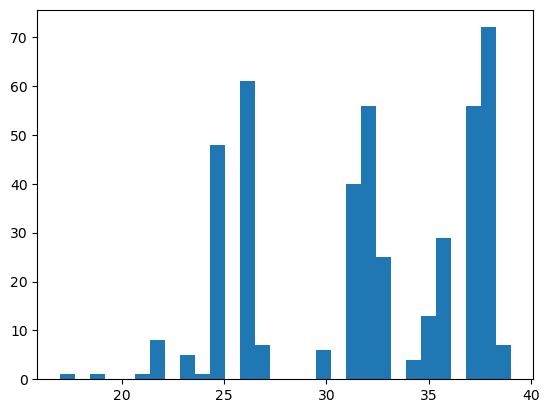

In [160]:
px_w = []
px_h = []

for fname in fnames_labelfile:
    _, df = get_image_and_bbx_df(fname)
    px_w.append(df['px_width'].values)
    px_h.append(df['px_height'])

px_w = [value for sublist in px_w for value in sublist]
px_h = [value for sublist in px_h for value in sublist]

px_max = [max(px_w[i], px_h[i]) for i in range(len(px_w))]

plt.hist(px_max, bins=30)
plt.show()

In [162]:
def get_crop(img_array, img_bbx_data, crop_size, x1, y1, max_transl, intersect_padding):

    x2 = x1+crop_size
    y2 = y1+crop_size

    # start by validating the crop, making sure it's actually in the image
    def validate_crop(x1, x2, y1, y2):
        if x2 > img_array.shape[1]:
            x1 = img_array.shape[1] - crop_size
            x2 = img_array.shape[1]
            # print("crop not ok")
            # print(f"new x1 value: {x1}")

        if y2>img_array.shape[0]:
            y1 = img_array.shape[0] - crop_size
            y2 = img_array.shape[0]
            # print("crop not ok")
            # print(f"new y1 value: {y1}")
 
        return x1, x2, y1, y2
    

    # check if the edges of the crop intersect a symbol
    def check_intersect(x1=x1, x2=x2, y1=y1, y2=y2):
        for index, row in img_bbx_data.iterrows():

            if (row["xmin"]-intersect_padding < x1 < row["xmax"]+intersect_padding) or \
            (row["xmin"]-intersect_padding < x2 < row["xmax"]+intersect_padding) or \
            (row["ymin"]-intersect_padding < y1 < row["ymax"]+intersect_padding) or \
            (row["ymin"]-intersect_padding < y2 < row["ymax"]+intersect_padding):
                
                return True # a new crop has
            
        return False
    

    def constrain_translation(x1, x2, y1, y2):
        transl_multip = [-1, 1, -1, 1]

        if x1 == 0: # currently at the left edge of the image
            transl_multip[0] = 0

        if x2 == img_array.shape[1]: # crop currently outside the right edge of the image
            transl_multip[1] = 0

        if y1 == 0: # currently scanning top edge of image
            transl_multip[2] = 0

        if y2 == img_array.shape[0]: # crop currently outside the right edge of the image
            transl_multip[3] = 0
        
        return transl_multip
    

    def get_symbols_in_crop():

        idxs = []        
        for index, row in img_bbx_data.iterrows():
            if ((x1 < row["xmin"]) and (x2 > row["xmax"])) and ((y1 < row["ymin"]) and (y2 > row["ymax"])):
                idxs.append(index)

        df = img_bbx_data.iloc[idxs, ::].copy()
        df.loc[:,'xmin'] = df['xmin'] -x1
        df.loc[:,'xmax'] = df['xmax'] -x1
        df.loc[:,'ymin'] = df['ymin'] -y1
        df.loc[:,'ymax'] = df['ymax'] -y1
        df['crop_size'] = crop_size

        df = df[['type', 'xmin', 'xmax', 'ymin', 'ymax', 'crop_size']]

        return df


    # ensure the crop is in the image
    x1, x2, y1, y2 = validate_crop(x1, x2, y1, y2)


    if check_intersect():

        transl_multip = constrain_translation(x1, x2, y1, y2)

        # set candidate variables
        x1c = x1
        x2c = x2
        y1c = y1
        y2c = y2

        p0=0.05
        p=0.05
        i = 0

        while True:
            
            # always create new candidates from the original x1, y1
            x1c = x1 + np.random.randint(transl_multip[0]*p*max_transl, transl_multip[1]*p*max_transl)
            x2c = x1c + crop_size
            y1c = y1 + np.random.randint(transl_multip[2]*p*max_transl, transl_multip[3]*p*max_transl)
            y2c = y1c + crop_size

            # validate candidates
            x1c, x2c, y1c, y2c = validate_crop(x1c, x2c, y1c, y2c)

            # check so that they don't intersect
            if check_intersect(x1c, x2c, y1c, y2c) == False:
                x1 = x1c
                x2 = x2c
                y1 = y1c
                y2 = y2c


                crop_img = img_array[y1:y2, x1:x2, ::]
                crop_bbx_data = get_symbols_in_crop()
                # print(i, p, x1, y1)

                break

            if p < 1 and i%10 == 0: # increment p by p0 every tenth iteration
                p += p0

            if i == 1000:
                # print("cannot find a crop without intersecting any symbol(s)")
                x1 = -1
                y1 = -1
                crop_img = np.array([[[255, 255, 255]]]) # one white pixel
                crop_bbx_data = pd.DataFrame()

                break

            i +=1
    else:
        crop_img = img_array[y1:y2, x1:x2, ::]
        crop_bbx_data = get_symbols_in_crop()


    return x1, y1, crop_img, crop_bbx_data


### Test the get_crop function

Start by getting the image and the associated df with the bounding box data

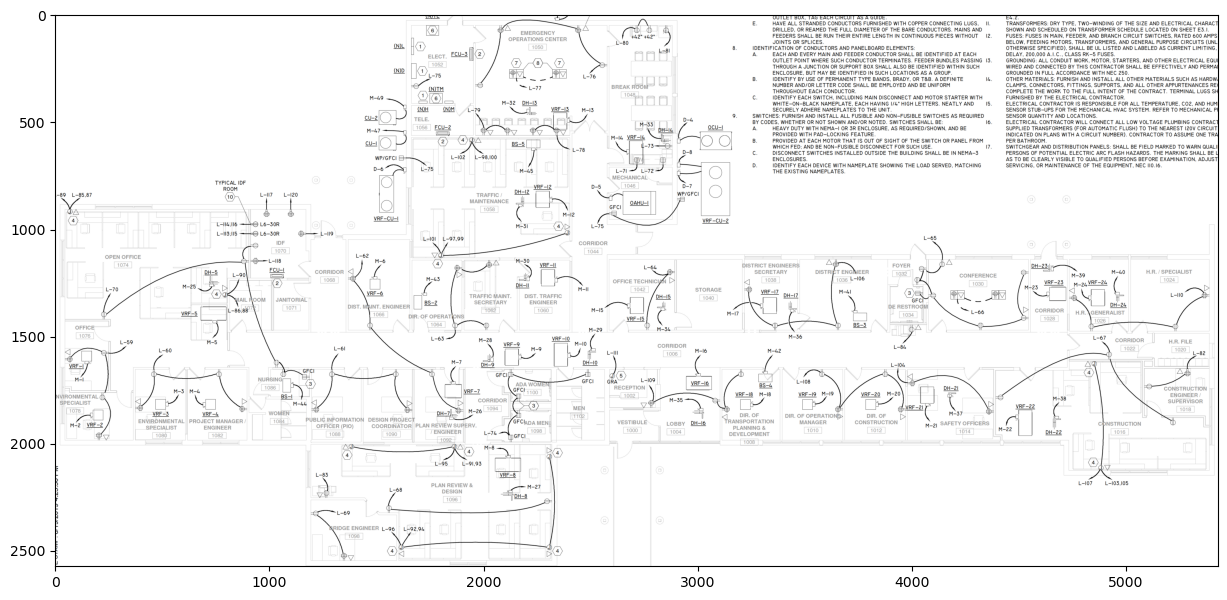

In [163]:
imgfile, df = get_image_and_bbx_df('plan06_2019-08_13-18177-plans_69b.png')
imgfile_array = np.array(imgfile)

plt.figure(figsize=(15,8))
plt.imshow(imgfile_array)
plt.show()

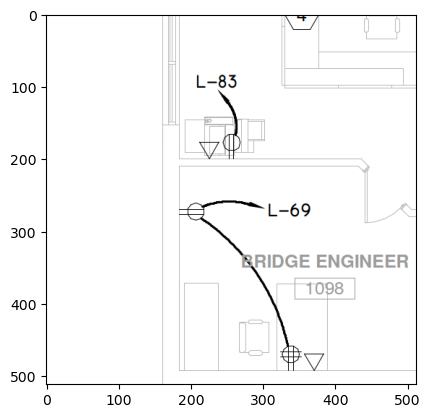

In [164]:
x1, y1, out_img, crop_bbx_data = get_crop(img_array=imgfile_array, img_bbx_data=df, crop_size=512, x1=1000, y1=2500, max_transl=75, intersect_padding=5)
# x1, y1, out_img, crop_bbx_data = get_crop(img_array=imgfile_array, img_bbx_data=df, crop_size=512, x1=0, y1=1718, max_transl=75, intersect_padding=5)
plt.imshow(out_img)
plt.show()

In [165]:
crop_bbx_data

,type,xmin,xmax,ymin,ymax,crop_size
20,duplex,243.0,270.0,164.0,201.0,512
21,duplex,183.0,221.0,259.0,287.0,512
22,quad,323.0,355.0,457.0,495.0,512


In [166]:
def generate_crop_seeds(img_array, crop_size, target_overlap):

    x1 = []
    y1 = []

    xmax = img_array.shape[1]-crop_size
    ymax = img_array.shape[0]-crop_size

    nx_steps = int(np.ceil(xmax/(crop_size*(1-target_overlap))))
    ny_steps = int(np.ceil(ymax/(crop_size*(1-target_overlap))))
    x = list(np.linspace(0, xmax, nx_steps+1))
    y = list(np.linspace(0, ymax, ny_steps+1))

    overlap = (round(1-x[1]/crop_size,2), round(1-y[1]/crop_size,2))


    for xval in x:
        for yval in y:
            x1.append(int(round(xval, 0)))
            y1.append(int(round(yval, 0)))

    return x1, y1, overlap

#### Test the generate_crop_seeds function

nr. of seed locations: 98
resulting overlap: (0.26, 0.33)


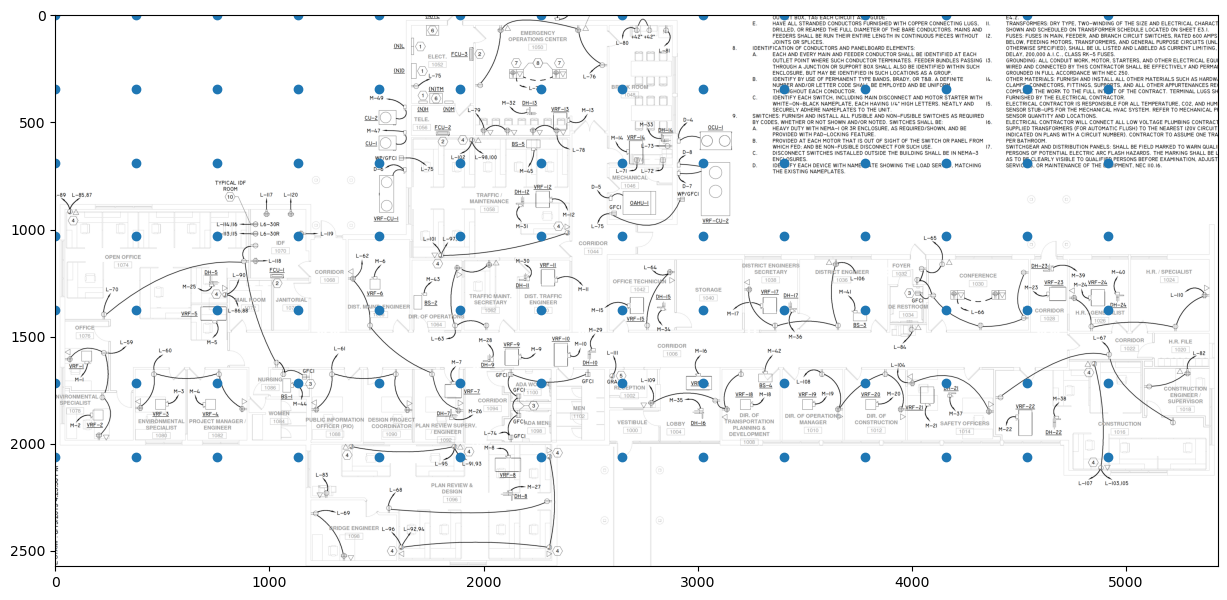

In [167]:
crop_size=512

x1, y1, overlap =generate_crop_seeds(img_array=imgfile_array, crop_size=512, target_overlap=0.2)
print("nr. of seed locations:", len(x1))
print("resulting overlap:", overlap)

plt.figure(figsize=(15,8))
plt.imshow(imgfile_array)
plt.scatter(x1,y1)
plt.show()

#### Generate n crops and show them if they contain symbols

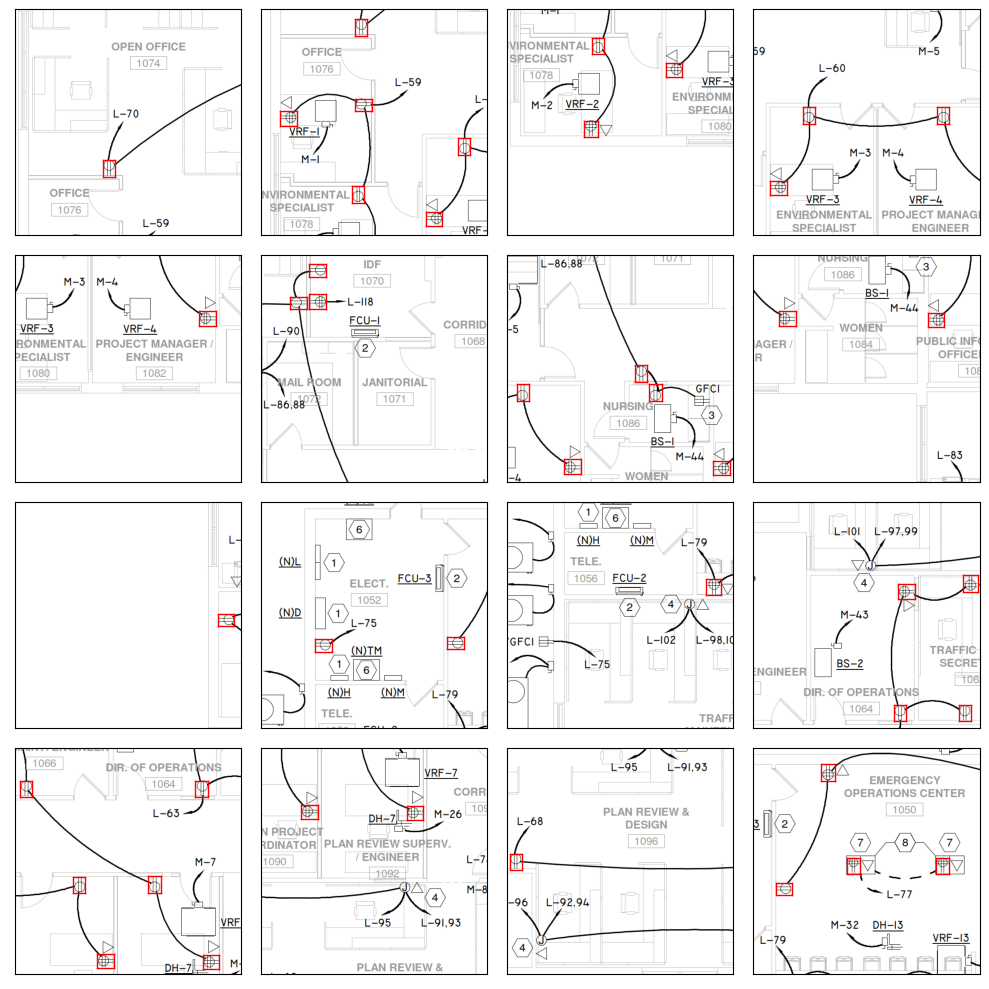

In [104]:
n = 16
crop_size=512

x_seed, y_seed, overlap =generate_crop_seeds(img_array=imgfile_array, crop_size=crop_size, target_overlap=0.2)


plt.figure(figsize=(10,10))
j=1
for i in range(len(x_seed)):
    # print(x_seed[i], y_seed[i])
    _, _, out_img, crop_bbx_data = get_crop(img_array=imgfile_array, img_bbx_data=df, crop_size=crop_size, x1=x_seed[i], y1=y_seed[i], max_transl=75, intersect_padding=3)

    if crop_bbx_data.empty == False:
        plt.subplot(4,4,j)
        plt.imshow(out_img)
        for idx, row in crop_bbx_data.iterrows():
            plt.plot([row['xmin'], row['xmax']], [row['ymin'], row['ymin']], color='red', linewidth=1)
            plt.plot([row['xmin'], row['xmin']], [row['ymax'], row['ymin']], color='red', linewidth=1)
            plt.plot([row['xmax'], row['xmax']], [row['ymax'], row['ymin']], color='red', linewidth=1)
            plt.plot([row['xmin'], row['xmax']], [row['ymax'], row['ymax']], color='red', linewidth=1)
        plt.xticks([])
        plt.yticks([])

        j+=1
        
    if j>n:
        break    

plt.tight_layout()

#### Save (up to) n crops + yolo label-files (.txt)

In [168]:
n_max = 9999
crop_size=512
target_overlap = 0.8
output_dir = "../data/manually_labeled_training/_temp_output_dir/"

os.makedirs(output_dir+"labels/")
os.makedirs(output_dir+"images/")

j=1
for fname in fnames_labelfile:

    imgfile, df = get_image_and_bbx_df(fname)
    imgfile_array = np.array(imgfile)

    x_seed, y_seed, overlap =generate_crop_seeds(img_array=imgfile_array, crop_size=crop_size, target_overlap=target_overlap)

    for i in range(len(x_seed)):
        _, _, out_img, crop_bbx_data = get_crop(img_array=imgfile_array, img_bbx_data=df, crop_size=crop_size, x1=x_seed[i], y1=y_seed[i], max_transl=75, intersect_padding=3)

        if crop_bbx_data.empty == False:

            txt_fname = output_dir + "labels/" + str(j).zfill(4) + "_" + fname[:-4] + ".txt"
            img_fname = output_dir + "images/" + str(j).zfill(4) + "_" + fname

            temp_image = Image.fromarray(out_img)
            temp_image.save(img_fname)

            with open(txt_fname, mode="w") as f:
                k=1
                for idx, row in crop_bbx_data.iterrows():
                    x1rel = (row['xmin']+row['xmax'])/2/row['crop_size']
                    y1rel = (row['ymin']+row['ymax'])/2/row['crop_size']
                    wrel = (row['xmax']-row['xmin'])/row['crop_size']
                    hrel = (row['ymax']-row['ymin'])/row['crop_size']
                    label = label_dict[row['type']]

                    f.write(f"{label} {x1rel} {y1rel} {wrel} {hrel}")

                    if k!= len(crop_bbx_data):
                        f.write("\n")
                    k+=1       
            j+=1
            
        if j>n_max:
            break    

In [169]:
# split into train, valid and test folders
train_split = 0.25
valid_split = 0.25
test_split = 0.5

os.makedirs(output_dir+"train/images")
os.makedirs(output_dir+"train/labels")
os.makedirs(output_dir+"valid/images")
os.makedirs(output_dir+"valid/labels")
os.makedirs(output_dir+"test/images")
os.makedirs(output_dir+"test/labels")

imagelist = os.listdir(output_dir+"images")
labellist = os.listdir(output_dir+"labels")
n = len(imagelist)

idx_set = [i for i in range(0,n)]
idx_train_set = random.sample(idx_set, int(n*train_split))
idx_set = [i for i in idx_set if i not in idx_train_set]
idx_valid_set = random.sample(idx_set, int(n*valid_split))
idx_test_set = [i for i in idx_set if i not in idx_valid_set]

for idx in idx_train_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"train/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"train/labels/"+labellist[idx])
for idx in idx_valid_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"valid/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"valid/labels/"+labellist[idx])
for idx in idx_test_set:
    os.rename(output_dir+"images/"+imagelist[idx], output_dir+"test/images/"+imagelist[idx])
    os.rename(output_dir+"labels/"+labellist[idx], output_dir+"test/labels/"+labellist[idx])

os.rmdir(output_dir+"images/")
os.rmdir(output_dir+"labels/")

In [ ]:
# imgfiles = os.listdir(output_dir+ "images/")


# train = random.sample(imgfiles, 800)
# test = [imgfile for imgfile in imgfiles if imgfile not in train]
# print("total image count:", len(imgfiles))
# print(len(train))
# print(len(test))


# with open(output_dir + "train.txt", 'w') as f:
#     for filename in train:
#         string = "./data/images/" + filename + "\n"
#         f.write(string)

# f.close()

# with open(output_dir + "valid.txt", 'w') as f:
#     for filename in test:
#         string = "./data/images/" + filename + "\n"
#         f.write(string)

# f.close()

In [10]:
def plot_symbols(fname, symbol_size):
    imgfile, df = get_image_and_bbx_df(fname)
    imgfile_array = np.array(imgfile)

    print("image file:", fname)
    print("image dimensions:", imgfile_array.shape)

    n_items = len(df)
    nw = 8
    nh = int(np.ceil(n_items/nw))

    plt.figure(figsize=((symbol_size*2),round((symbol_size*2*nh)/nw,1)))

    for i in range(n_items):
        xmin = int(df.iloc[i,16])
        xmax = int(df.iloc[i,17])
        ymin = int(df.iloc[i,18])
        ymax = int(df.iloc[i,19])

        cropped_img_array = imgfile_array[ymin:ymax, xmin:xmax, ::]
        plt.subplot(nh, nw, i+1)
        plt.imshow(cropped_img_array)
        plt.title(f"{i}: {df.iloc[i,0]}")
        plt.axis("off")
    plt.tight_layout()

image file: plan01_2019-02_RFC_38-18197-Rebid-Plans_24.png
image dimensions: (2340, 2548, 4)


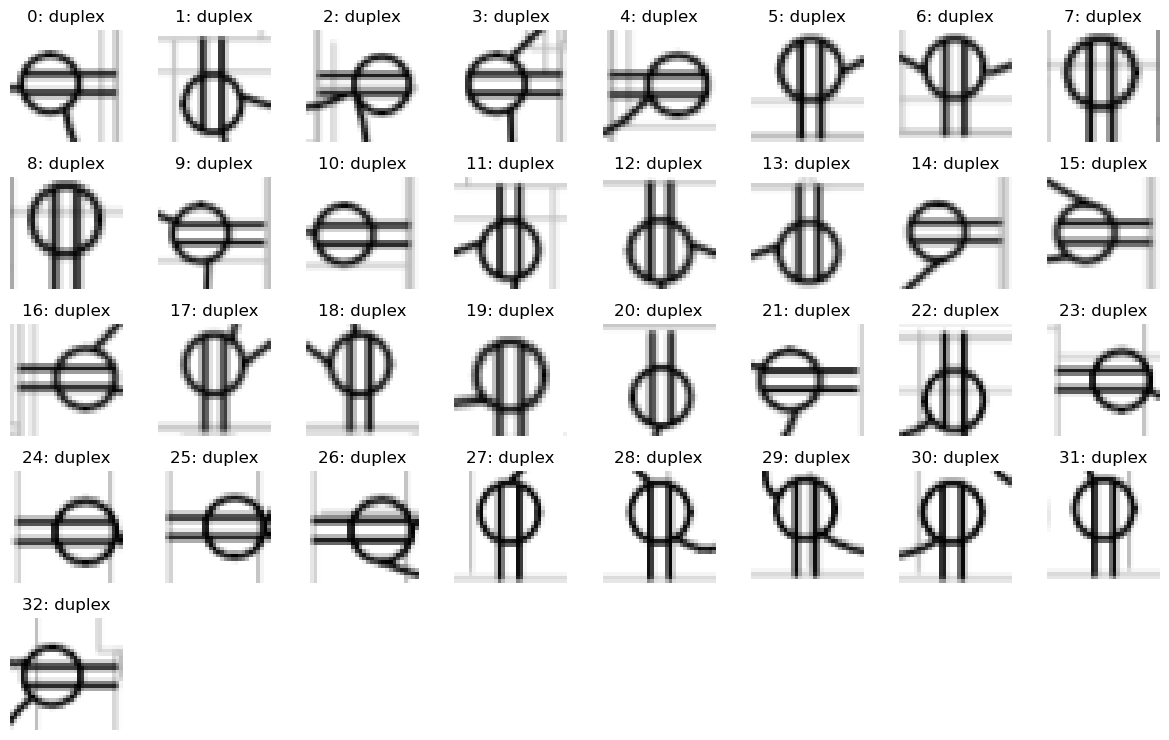

In [236]:
plot_symbols(fnames_labelfile[0], symbol_size=6)

image file: plan02_2019-06_05-18241-plans_28.png
image dimensions: (2612, 3861, 4)


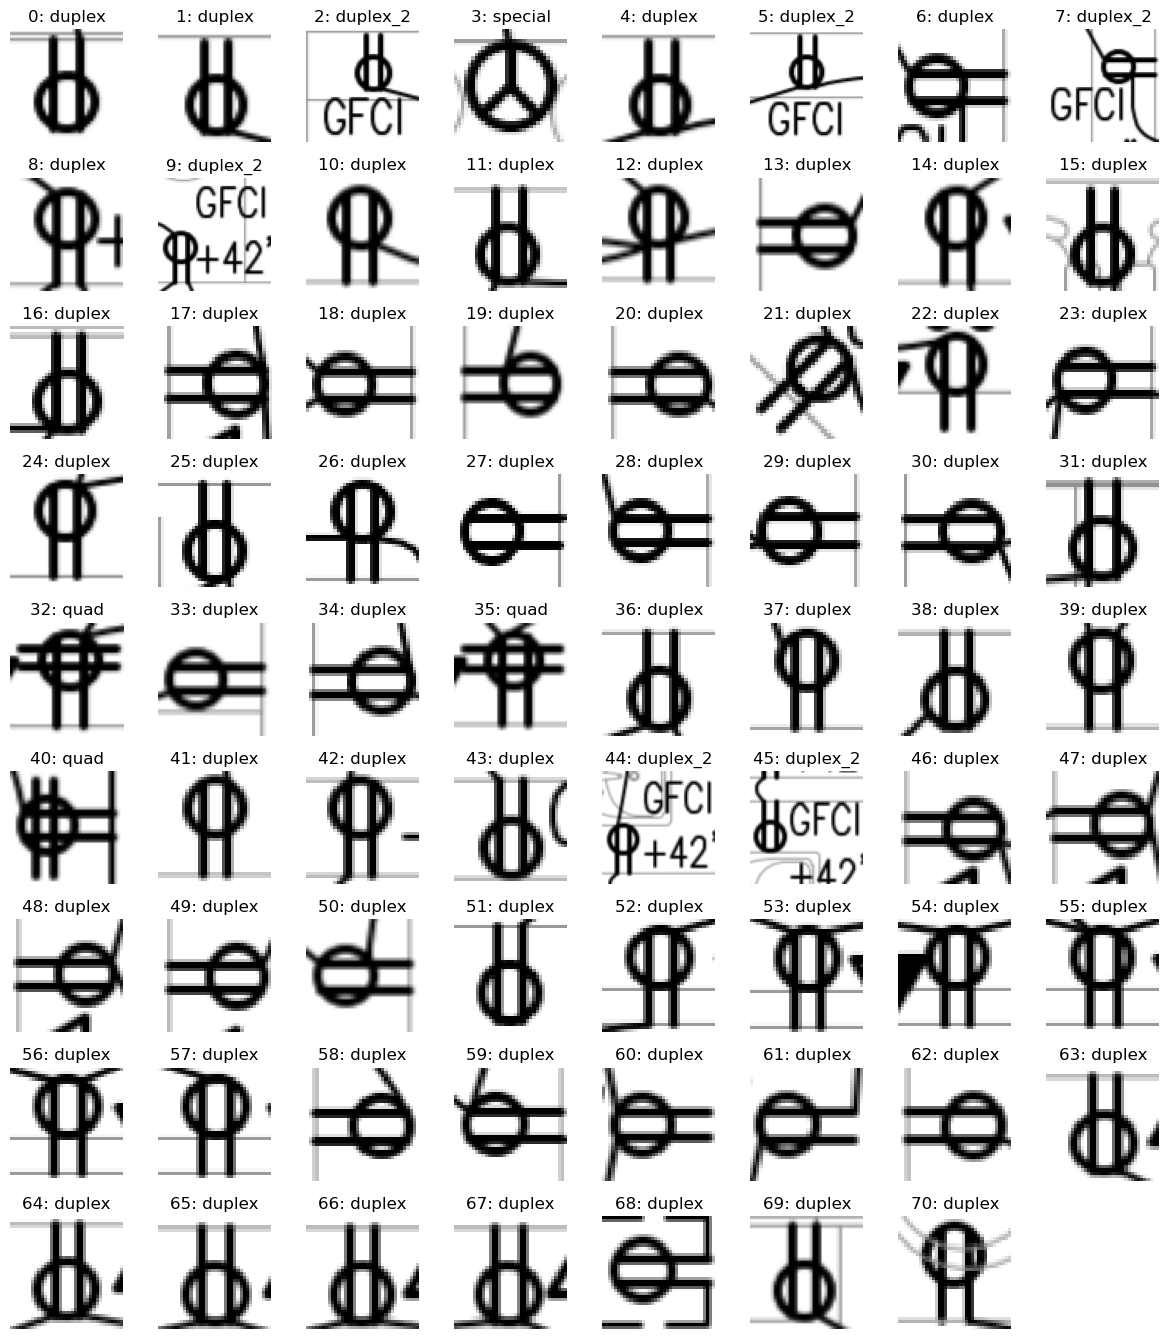

In [237]:
plot_symbols(fnames_labelfile[1], symbol_size=6)

image file: plan03_2019-06_15-18158-plans_76.png
image dimensions: (1222, 2365, 4)


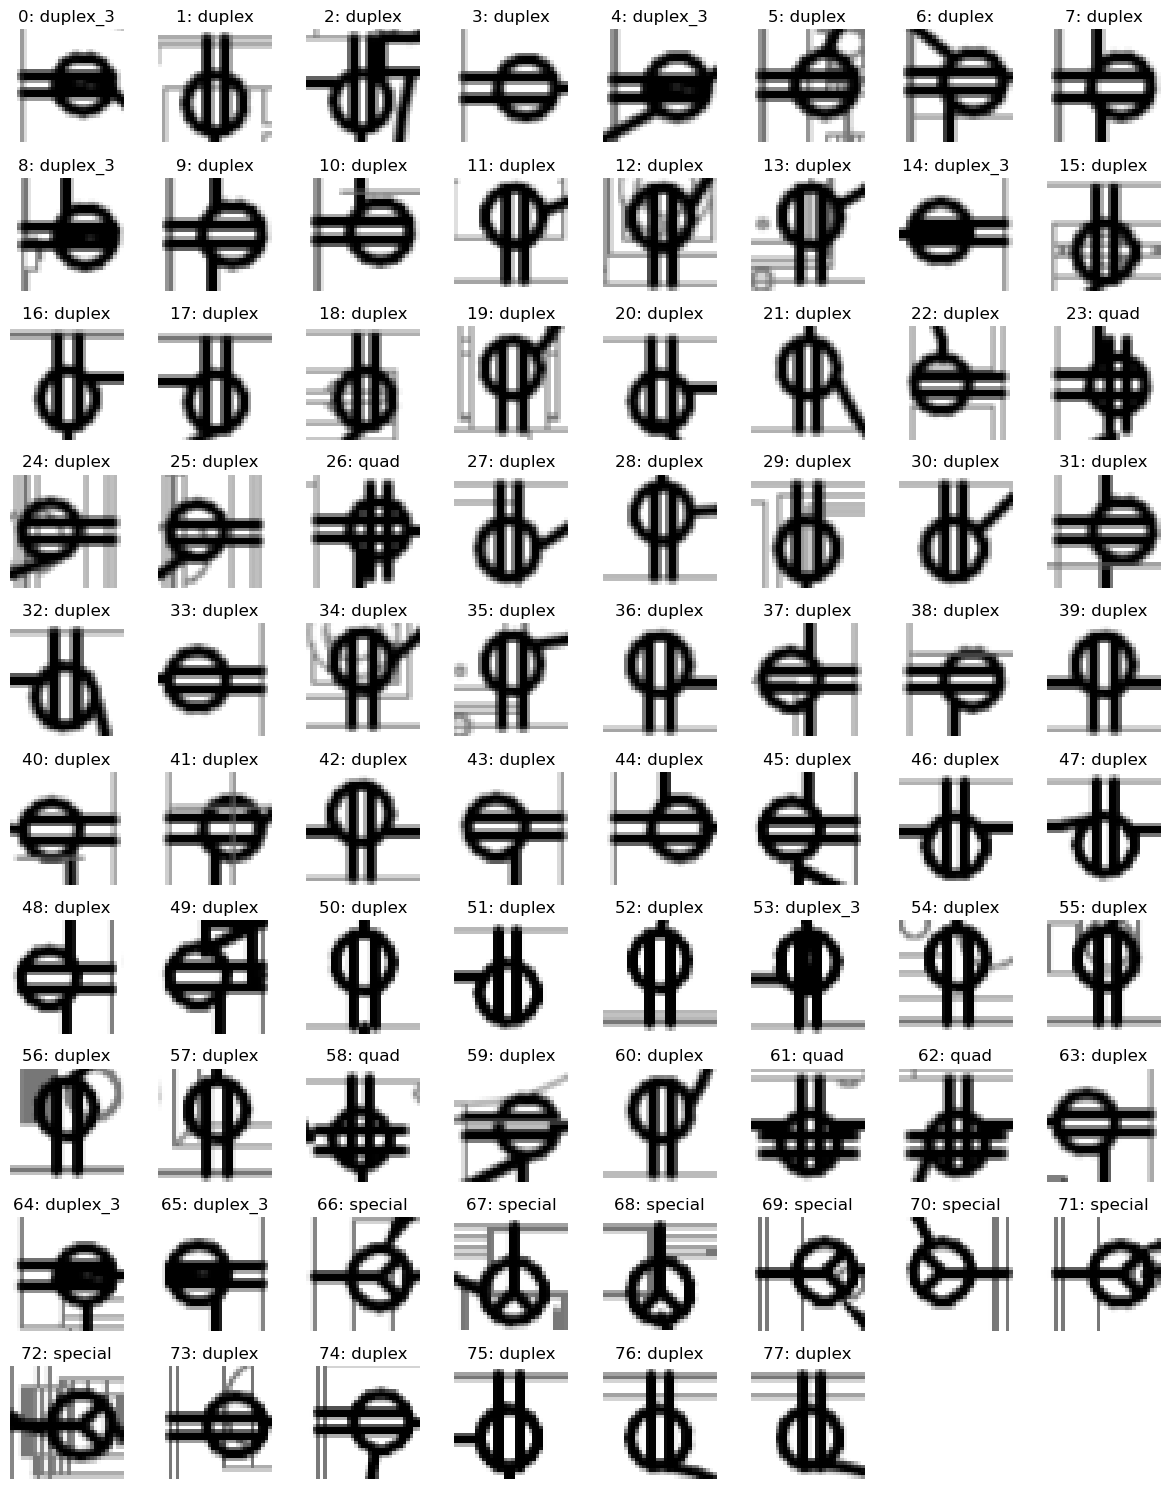

In [238]:
plot_symbols(fnames_labelfile[2], symbol_size=6)

image file: plan04_2019-06_RFC_15-18248-plans_14.png
image dimensions: (1092, 2381, 4)


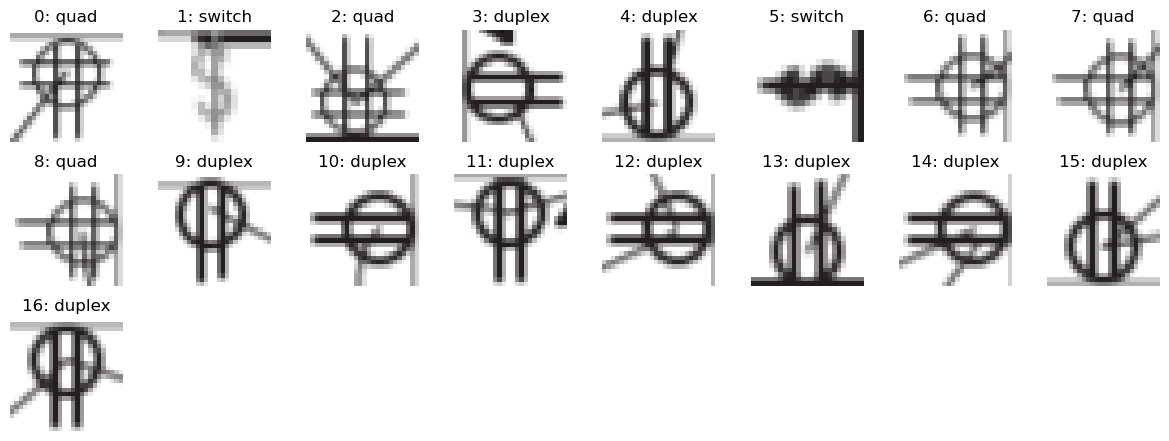

In [239]:
plot_symbols(fnames_labelfile[3], symbol_size=6)

image file: plan05_2019-07_VCSLC_16-18700-plans_96.png
image dimensions: (1644, 3672, 4)


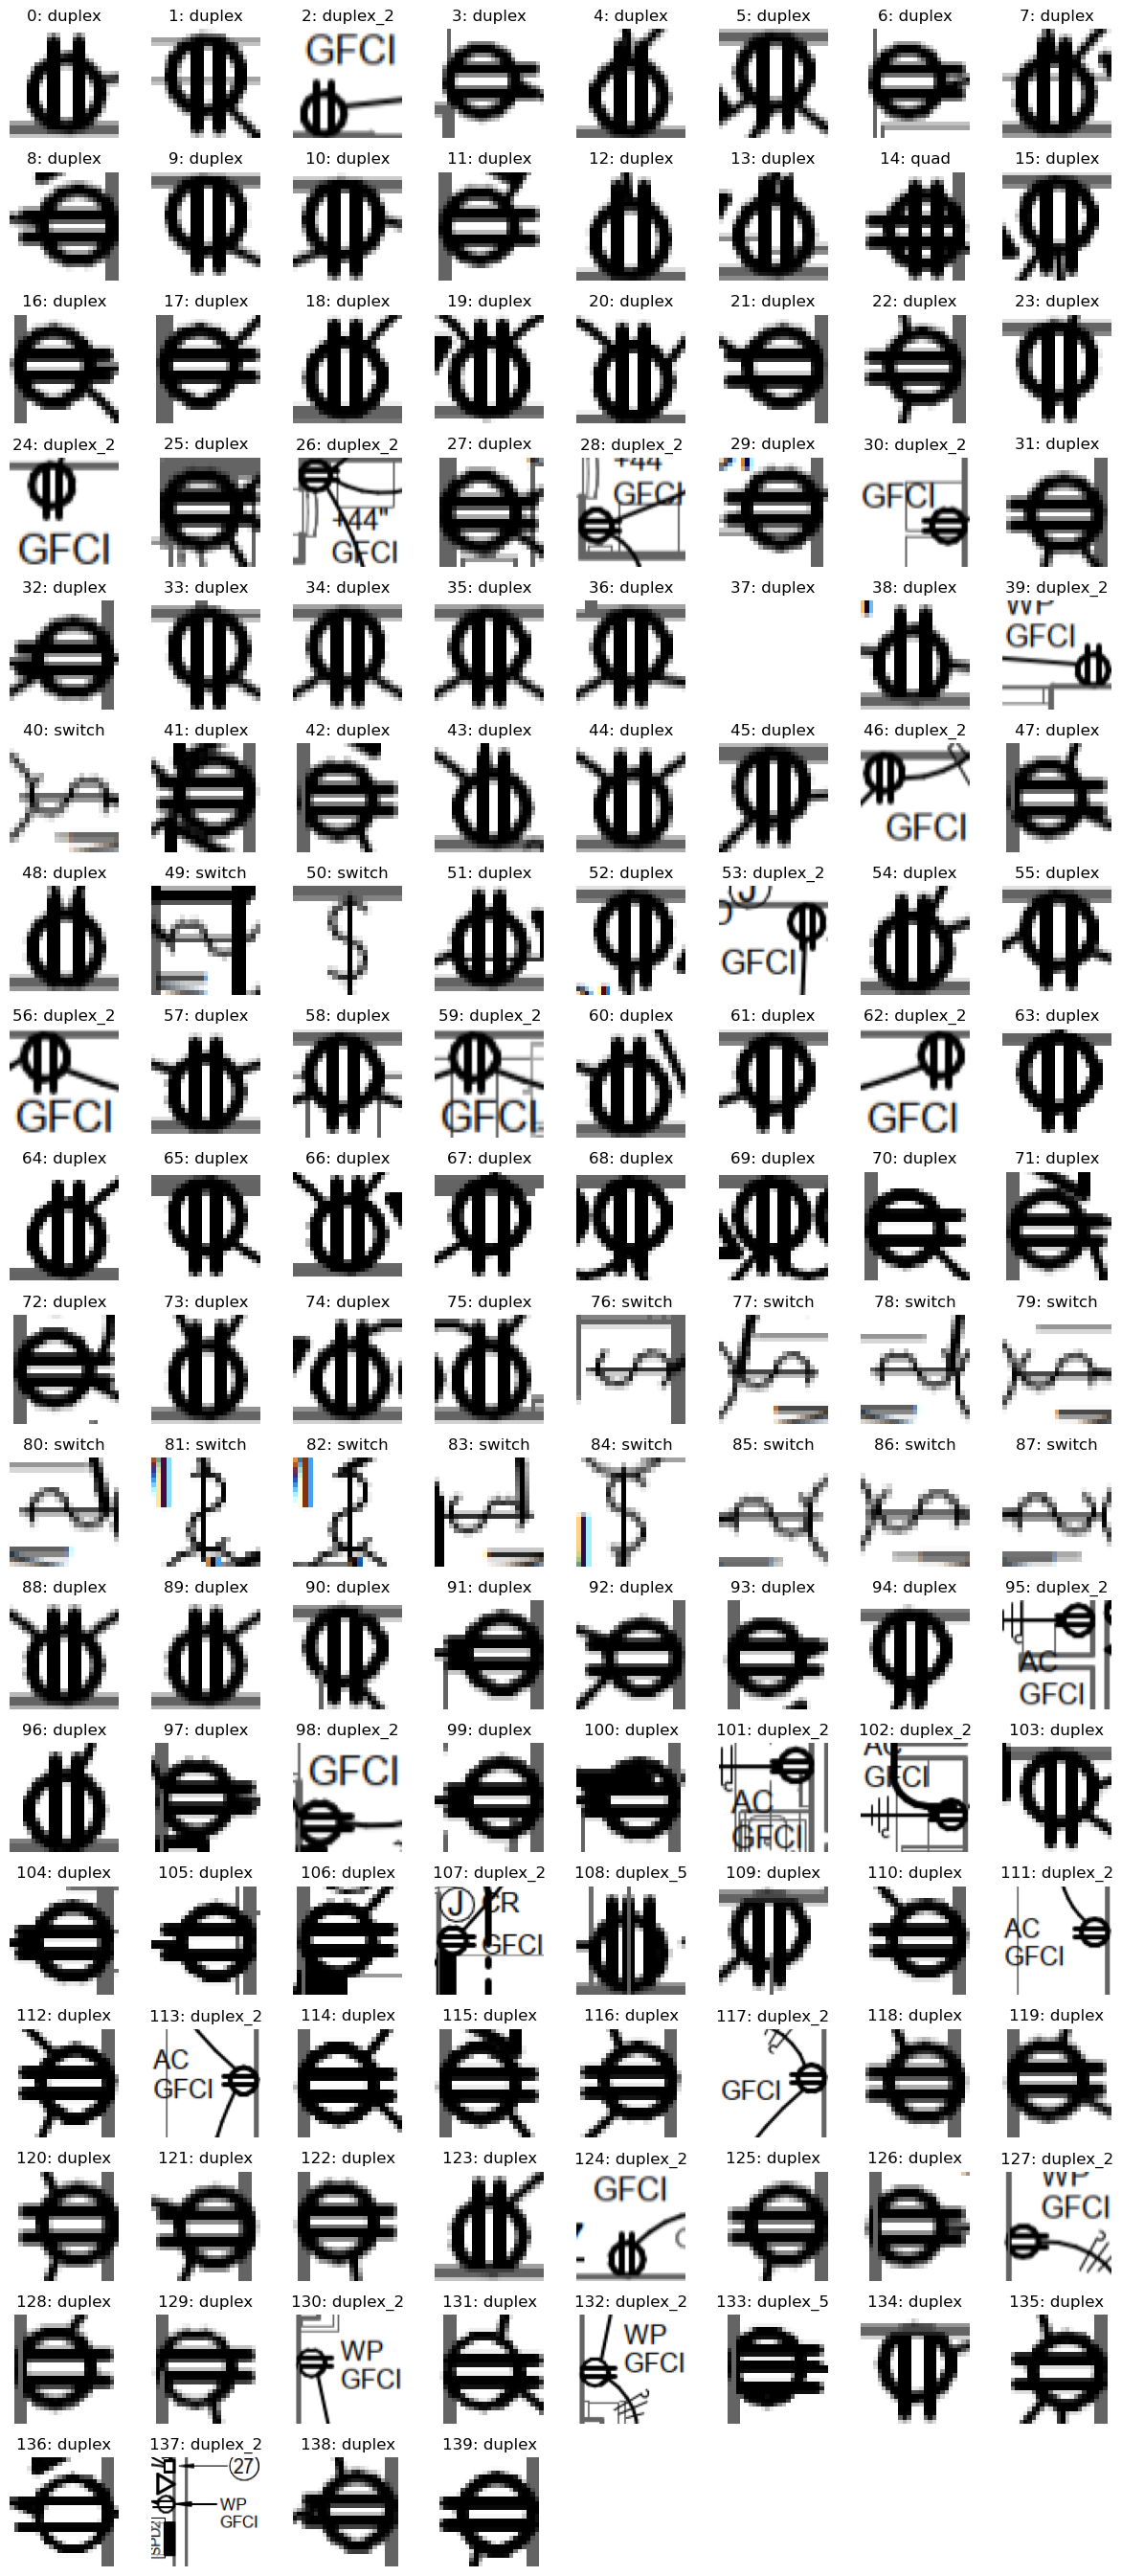

In [240]:
plot_symbols(fnames_labelfile[4], symbol_size=6)

image file: plan06_2019-08_13-18177-plans_70.png
image dimensions: (1923, 1713, 4)


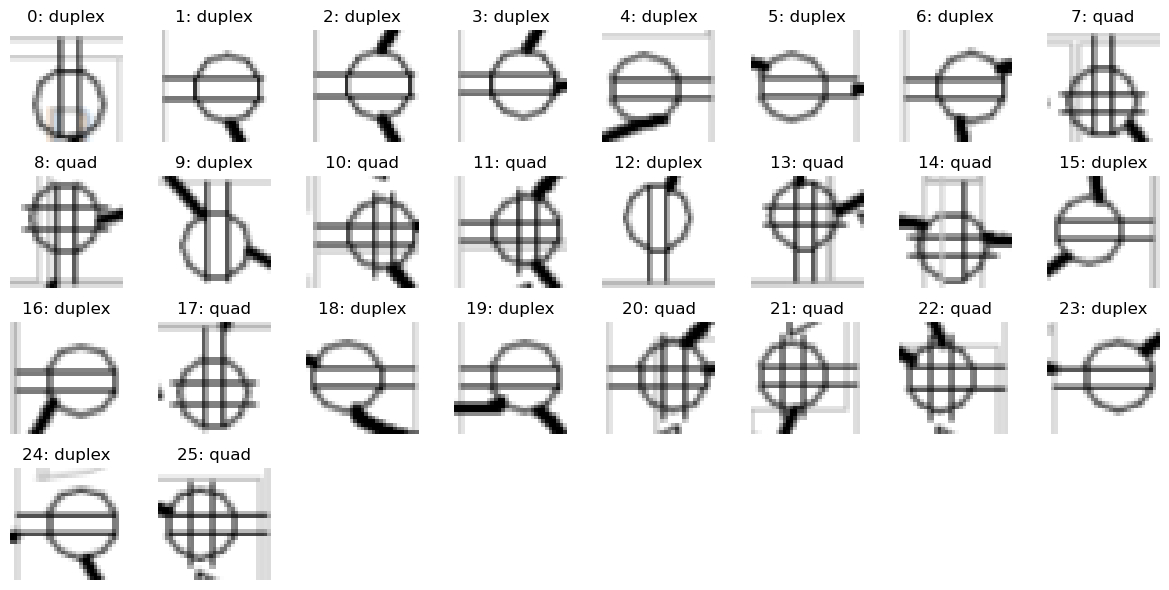

In [241]:
plot_symbols(fnames_labelfile[5], symbol_size=6)

image file: plan07_2019-08_Bexar_0915-12-602_62.png
image dimensions: (1682, 1242, 4)


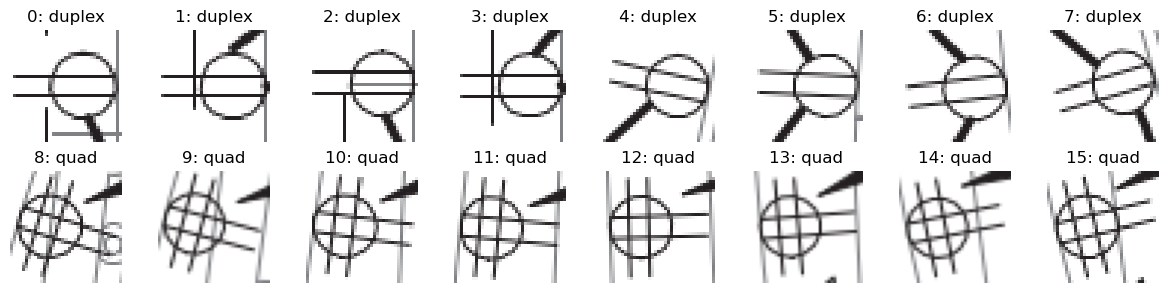

In [242]:
plot_symbols(fnames_labelfile[6], symbol_size=6)

image file: plan08_2019-08_Culberson_0003-01-055_Vol_2_181.png
image dimensions: (1581, 3080, 4)


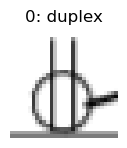

In [243]:
plot_symbols(fnames_labelfile[7], symbol_size=6)

In [ ]:
# labeling not completed for plan08_2019-08_Culberson_0003-01-055_Vol_2_181.png

image file: plan06_2019-08_13-18177-plans_69b.png
image dimensions: (2573, 5429, 4)


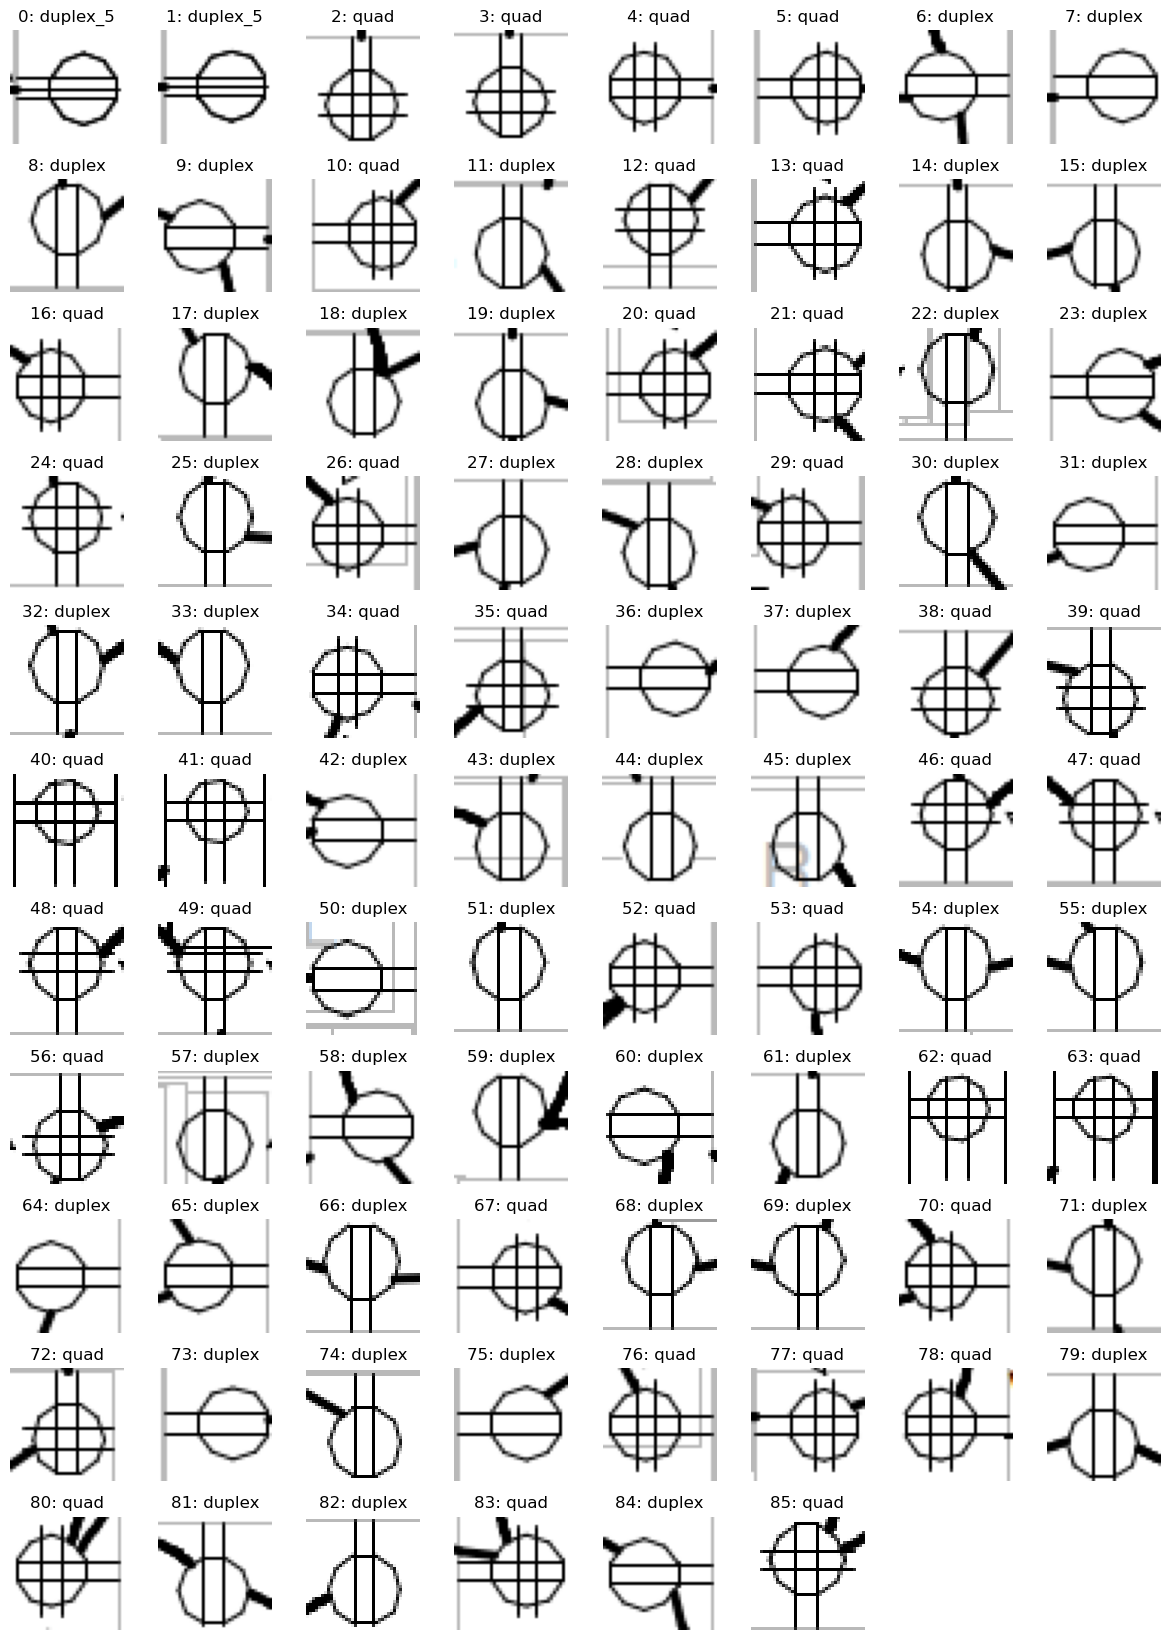

In [244]:
plot_symbols(fnames_labelfile[8], symbol_size=6)

In [245]:
plot_symbols(fnames_labelfile[9], symbol_size=6)

IndexError: list index out of range